In [15]:
import torch
import torch.nn as nn
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoConfig, OPTForCausalLM, MistralForCausalLM

/home/dingfangyu/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
model_id = 'facebook/opt-125m'

model = AutoModelForCausalLM.from_pretrained(model_id, torch_dtype=torch.float16)

In [20]:
model.model.decoder.layers[0].self_attn.k_proj.weight

Parameter containing:
tensor([[ 7.8796e-02,  9.4938e-04,  6.5308e-03,  ..., -4.6875e-02,
          3.9642e-02,  1.1843e-04],
        [ 2.0361e-01,  1.6589e-01, -3.3989e-03,  ..., -4.5959e-02,
         -4.7058e-02, -4.8035e-02],
        [ 3.6865e-02,  1.2341e-01,  3.0731e-02,  ..., -8.3252e-02,
          2.4887e-02,  1.9882e-02],
        ...,
        [ 8.6426e-02,  2.7046e-03, -4.4518e-03,  ..., -1.8738e-02,
          2.8839e-02,  4.8431e-02],
        [ 9.1064e-02,  6.3049e-02,  7.2327e-02,  ..., -1.2463e-01,
          1.1230e-01,  2.4750e-02],
        [-9.3460e-04, -2.8748e-02,  2.5269e-02,  ...,  3.5706e-02,
         -1.1932e-01,  3.1067e-02]], dtype=torch.float16, requires_grad=True)

In [9]:
import torch
from torch.linalg import matrix_rank, svd

In [37]:
h = 8192
# W = torch.randn(h, h // 8)
W = model.model.decoder.layers[0].self_attn.k_proj.weight
W[0][:10]

tensor([ 0.0788,  0.0009,  0.0065, -0.1289,  0.0651,  0.0264,  0.1558,  0.0141,
        -0.1201,  0.0341], dtype=torch.float16, grad_fn=<SliceBackward0>)

In [58]:
# _W = W.to(torch.float32) #
_W = torch.cat((model.model.decoder.layers[0].self_attn.k_proj.weight, model.model.decoder.layers[0].self_attn.v_proj.weight), dim=1).to(torch.float32)
matrix_rank(_W)

tensor(768)

In [44]:
u, s, v = torch.svd(_W)

rec = u @ torch.diag(s) @ v.mT
_W[0][:10], rec[0][:10]
torch.dist(rec, _W)


tensor(9.2697e-05, grad_fn=<DistBackward0>)

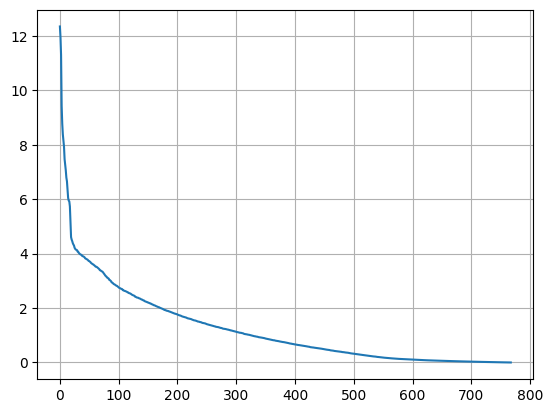

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline 
plt.plot(s.detach().numpy())
plt.grid()

In [56]:
u, s, v = torch.svd(_W)
s[-len(s)//20:] = 0

rec = u @ torch.diag(s) @ v.mT
print(_W[0][:10],'\n', rec[0][:10])
torch.dist(rec, _W)


tensor([ 0.0788,  0.0009,  0.0065, -0.1289,  0.0651,  0.0264,  0.1558,  0.0141,
        -0.1201,  0.0341], grad_fn=<SliceBackward0>) 
 tensor([ 0.0788,  0.0009,  0.0066, -0.1289,  0.0651,  0.0264,  0.1557,  0.0140,
        -0.1201,  0.0341], grad_fn=<SliceBackward0>)


tensor(0.0563, grad_fn=<DistBackward0>)